### create figure for hierarchy example
1. get latent distances vs sequential distances
2. get MI of markov model
3. get MI of recursively generated sequence - store the average latent distance for each of the sequential distances
4. Plot latent distance by MI
5. plot sequential distance by MI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import random as sr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
np.random.seed(1)

In [4]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [5]:
def gen_balanced_matrix(na=5, ps=[0.7, 0.2, 0.1]):
    """ Generates a balanced matrix in which every state can reach every other state
    for hierarchical and Markov models
    """
    for r in range(1000):
        breakme = False
        probs = np.zeros((na, na))
        for p in ps:
            for i in np.arange(na):
                ixloc = np.where(
                    (probs[i, :] == 0) & (np.sum(probs != p, axis=0) == na)
                )[0]
                if len(ixloc) > 0:
                    probs[i, np.random.permutation(ixloc)[0]] = p
                else:
                    # the initialization didn't work
                    breakme = True
        if breakme:
            continue
        probs = probs / np.sum(probs, axis=0)
        return probs
    return "Generation Failed"

def gen_seq_hierarchical(alphabet, probs, depth, n_subsamples):
    """ generates a sequence via the Lin Tegmark recursive model
    Arguments:
        alphabet {[type]} -- [alphabet of states]
        probs {[type]} -- [probability matrix for recursive subsampling]
        depth {[type]} -- [how many times to recursively subsample]
        n_subsamples {[type]} -- [the number of new elements to recursively replace old elements with]
    
    Returns:
        sequence [type] -- [sequence of elements]
    """
    sequence = np.random.choice(
        alphabet, p=np.sum(probs, axis=1) / np.sum(probs), size=1
    )
    if type(depth) == list:
        depth = np.random.choice(depth)
    depth_list = range(depth)
    for i in depth_list:
        q = np.random.choice(n_subsamples)
        sequence = recursively_subsample_sequence(sequence, probs, q, alphabet)
    return sequence


def subsample_sequence(sequence, probs, q, alphabet):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    return [
        item
        for sublist in [
            np.random.choice(alphabet, p=probs[:, i], size=q) for i in sequence
        ]
        for item in sublist
    ]

def recursively_subsample_sequence(sequence, probs, q, alphabet):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    for i in sequence:
        if type(i) == list:
            return [recursively_subsample_sequence(i, probs, q, alphabet) for i in sequence]
        else:
            return [
                item
                for sublist in [
                    [list(np.random.choice(alphabet, p=probs[:, i], size=q))] for i in sequence
                ]
                for item in sublist
            ]

In [6]:
def gen_seq_markov(alphabet, probs, seq_len):
    """ like sample_sequence_MM, but uses a numpy matrix, no start and end states, and a set sequence length
    """
    sequence = list(
        np.random.choice(alphabet, p=np.sum(probs, axis=0) / np.sum(probs), size=1)
    )
    for i in tqdm(range(seq_len), leave=False):
        sequence.append(np.random.choice(alphabet, p=probs[:, sequence[-1]], size=1)[0])
    return sequence

In [7]:
# how many branches to sample in hierarchical
n_subsamples = [2]
# how many subsamples to perform
depth = 12
# alphabet size
a_n = 5
alphabet = np.arange(a_n)
# how many sequences to use
nseq = 1000
print('seq len ',(np.mean(n_subsamples)**depth))

seq len  4096.0


In [8]:
# how many markov items to sample 
markov_seq_len_range = [2,5]
# number of elements in markov alphabet
a_n_markov = 25
markov_alphabet_items = np.arange(a_n_markov)
# the number of sequences can correspond to each hierarchical element
markov_n_seq_per_element = 5

In [9]:
# generate probbility matrix 
probs = gen_balanced_matrix(na=a_n, ps=[.9, .1])

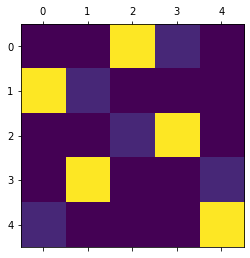

In [10]:
plt.matshow(probs)

In [11]:
# generate markov probabilities
markov_probs = np.random.rand(a_n_markov**2).reshape((a_n_markov, a_n_markov))**2
markov_probs = markov_probs/np.sum(markov_probs, axis = 0)
# test it out...
gen_seq_markov(markov_alphabet_items, markov_probs, 10)

[19, 17, 14, 0, 6, 5, 23, 17, 14, 18, 6]

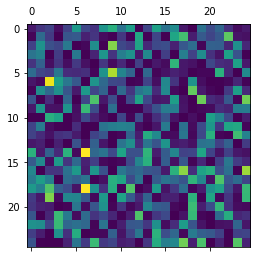

In [12]:
plt.matshow(markov_probs)

In [13]:
# each leaf in the tree grammar should correspond to a markov generated sequence
markov_alphabet = {i:[gen_seq_markov(markov_alphabet_items,
                                     markov_probs, 
                                     np.random.randint(markov_seq_len_range[0], markov_seq_len_range[1])
                                    ) for j in range(markov_n_seq_per_element)] for i in tqdm(markov_alphabet_items)}
markov_alphabet[alphabet[0]]

[[12, 7, 8, 3, 21],
 [24, 8, 14, 0],
 [1, 11, 14],
 [3, 15, 6, 18, 20],
 [6, 24, 21]]

In [14]:
from joblib import Parallel, delayed

In [15]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [16]:
sequences = Parallel(n_jobs = -1)(delayed(gen_seq_hierarchical)(alphabet, probs, depth, n_subsamples=n_subsamples) for seq in tqdm(range(nseq)))

In [17]:
len(sequences), len(list(flatten(sequences[0])))

(1000, 4096)

In [18]:
def replace_markov_alphabet_recursive(sequence, markov_alphabet, markov_n_seq_per_element):
    """ subsamples a sequence given a probability matrix
    
    given a sequence, resamples each element in that sequences given a probability matrix of sequence element to new elements
    
    Arguments:
        sequence {[type]} -- input sequence
        probs {[type]} -- the probability matrix
        q {[type]} -- the number of items to subsample
    """
    for i in sequence:
        if type(i) == list:
            return [replace_markov_alphabet_recursive(i,markov_alphabet, markov_n_seq_per_element) for i in sequence]
        else:
            return markov_alphabet[i][np.random.choice(sequence)]

In [19]:
def replace_markov_alphabet(seq, markov_alphabet,markov_n_seq_per_element):
    return [markov_alphabet[i][np.random.choice(markov_n_seq_per_element)] for i in seq]

In [20]:
# replace each element with Markov sampled sequences
#sequences_markov = Parallel(n_jobs = -1)(delayed(replace_markov_alphabet)(seq, markov_alphabet,markov_n_seq_per_element) for seq in tqdm(sequences))

In [21]:
# replace each element with Markov sampled sequences
sequences_markov = Parallel(n_jobs = -1)(delayed(replace_markov_alphabet_recursive)(seq, markov_alphabet,markov_n_seq_per_element) for seq in tqdm(sequences))

# MI

In [22]:
from childes_mi.information_theory import mutual_information as mi
# distances of MI to sample at
distances = np.arange(1,101)

### MI over sequences without Markov endpoints

In [23]:
flat_sequences = [list(flatten(i)) for i in tqdm(sequences)]

In [24]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    flat_sequences, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    5.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    5.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished


In [25]:
MI_DF =  pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "no_markov"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
)

(0.0001, 5)

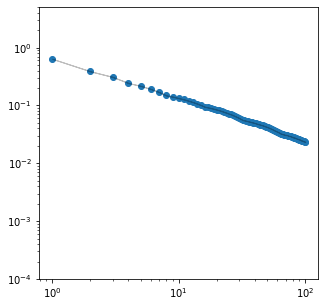

In [26]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-4, 5])

### MI over original data

In [27]:
sequences_flat = [list(flatten(i)) for i in tqdm(sequences_markov)]

In [28]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    sequences_flat, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.1s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   10.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished


In [29]:
MI_DF =  MI_DF.append([pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "original"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
)])

(0.0001, 5)

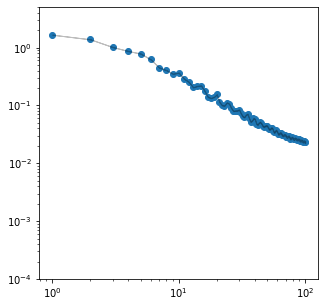

In [30]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-4, 5])

### shuffle "words" within "transcript"

In [31]:
import itertools

def recursively_concatenate_to_depth(sequence, depth, i=0):
    if depth ==i:
        return list(sequence)
    else:
        return recursively_concatenate_to_depth(list(itertools.chain.from_iterable(sequence)), depth, i=i+1)

In [32]:
words_within_transcript_list = [recursively_concatenate_to_depth(sequence, depth-1) for sequence in tqdm(sequences_markov)]

In [33]:
words_within_transcript_list[0]

[[22, 21, 5],
 [22, 21, 5],
 [15, 20, 0, 24],
 [22, 21, 5],
 [2, 6, 9, 18],
 [19, 24, 8],
 [2, 6, 9, 18],
 [19, 24, 8],
 [11, 12, 21, 11, 11],
 [22, 21, 5],
 [15, 2, 9],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [18, 23, 12, 23],
 [22, 21, 5],
 [15, 20, 0, 24],
 [15, 2, 9],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [11, 12, 21, 11, 11],
 [22, 21, 5],
 [18, 23, 12, 23],
 [22, 21, 5],
 [15, 2, 9],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [2, 6, 9, 18],
 [2, 6, 9, 18],
 [2, 6, 9, 18],
 [11, 12, 21, 11, 11],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [14, 23, 12],
 [12, 7, 8, 3, 21],
 [15, 2, 9],
 [22, 21, 5],
 [12, 7, 8, 3, 21],
 [12, 7, 8, 3, 21],
 [12, 7, 8, 3, 21],
 [2, 6, 9, 18],
 [2, 6, 9, 18],
 [2, 6, 9, 18],
 [15, 2, 9],
 [22, 21, 5],
 [22, 21, 5],
 [22, 21, 5],
 [12, 7, 8, 3, 21],
 [2, 6, 9, 18],
 [2, 6, 9, 18],
 [2, 6, 9, 18],
 [12, 7, 8,

In [34]:
shuffled_words_within_transcript_list = [np.concatenate(np.random.permutation(i)) for i in tqdm(words_within_transcript_list)]

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [35]:
len(shuffled_words_within_transcript_list), len(shuffled_words_within_transcript_list[0])

(1000, 7744)

In [36]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    shuffled_words_within_transcript_list, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.0s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.5s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   10.6s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished


In [37]:
MI_DF= MI_DF.append(pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "within_transcript_shuffle"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
))

(1e-06, 5)

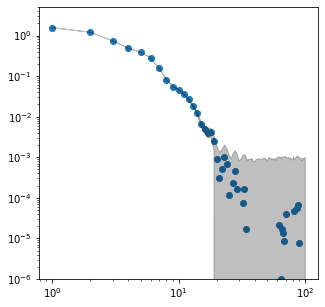

In [38]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-6, 5])

### shuffle within "word" (markov sequences)

In [39]:
within_markov_shuffle = [np.concatenate([np.random.permutation(word) for word in sequence]) for sequence in tqdm(words_within_transcript_list)]

In [40]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    within_markov_shuffle, distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.5s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.3s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   10.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished


In [41]:
MI_DF = MI_DF.append(pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "within_markov_shuffle"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
))

(0.0001, 5)

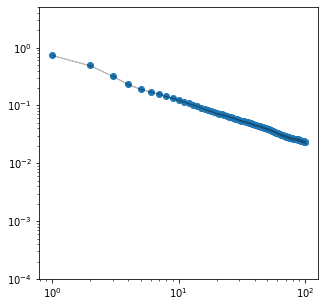

In [42]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-4, 5])

### shuffle within "utterance" (markov sequences)

In [43]:
len(list(flatten(recursively_concatenate_to_depth(sequences_markov[0], depth-3)[0])))

13

In [44]:
len(list(flatten(recursively_concatenate_to_depth(sequences_markov[0], depth-10)[0])))

1945

In [45]:
utterances_within_transcript_list = [list(recursively_concatenate_to_depth(sequence, depth-3)) for sequence in tqdm(sequences_markov)]

In [46]:
shuffled_within_utterance_list = [np.random.permutation(list(flatten(i))) for i in tqdm(utterances_within_transcript_list)]

In [47]:
import random

In [48]:
shuffled_within_utterance_list = [
    list(flatten([random.sample(list(flatten(utterance)), len(list(flatten(utterance)))) for utterance in trans]))
    for trans in tqdm(utterances_within_transcript_list)
]

In [49]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    shuffled_within_utterance_list, distances=distances, n_jobs=-1
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    7.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    9.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.4s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   10.7s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.3s finished


In [50]:
MI_DF = MI_DF.append(pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "within_utterance_shuffle"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
))

(0.0001, 5)

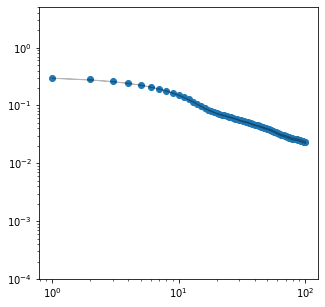

In [51]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-4, 5])

### shuffle "utterance" within transcript (markov sequences)

In [52]:
len(list(flatten(recursively_concatenate_to_depth(sequences_markov[0], depth-3)[0])))

13

In [73]:
utterances_within_transcript_list = [list(recursively_concatenate_to_depth(sequence, depth-4)) for sequence in tqdm(sequences_markov)]

In [74]:
utterances_within_transcript_list[0][0]

[[[[22, 21, 5], [22, 21, 5]], [[15, 20, 0, 24], [22, 21, 5]]],
 [[[2, 6, 9, 18], [19, 24, 8]], [[2, 6, 9, 18], [19, 24, 8]]]]

In [75]:
shuffled_utterances_within_transcript_list = [random.sample(i, len(i)) for i in utterances_within_transcript_list]
shuffled_utterances_within_transcript_list = [list(flatten(i)) for i in tqdm(shuffled_utterances_within_transcript_list)]

In [76]:
# original model
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    shuffled_utterances_within_transcript_list, distances=distances, n_jobs=-1
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.3s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   10.4s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.6s


[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    8.9s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   11.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished


In [77]:
MI_DF = MI_DF.append(pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances, "shuffle_utterance_within_transcript"]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "shuffle"],
))

(0.0001, 5)

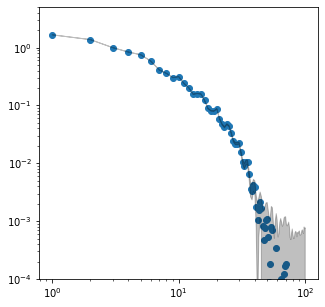

In [78]:
row = MI_DF.iloc[len(MI_DF)-1]
fig, ax = plt.subplots(figsize=(5,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-4, 5])

### get best fit model

In [91]:
!pip install lmfit

     |████████████████████████████████| 307kB 17.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/45/41/fc7e7b73b603e7c2c9e040b7aa8caf4a88d74b6faa567601ed82b6f0d8e1/uncertainties-3.1.5-py2.py3-none-any.whl
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=6c58e02c12999adb102f5c6d74fe28471b24440def5192caea8605fc2aa5dbbb
  Stored in directory: /home/AD/tsainbur/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.25-cp37-none-any.whl size=17289 sha256=989f1d593ec085c181d0f3174c48ca57db3c6ba8ed17e74da4c282a4222ceef0
  Stored in directory: /home/AD/tsainbur/.cache/pip/wheels/75/4e/83/fb48cc07d800283881ee75940ac6d7bae561305b3545e07785
Successfully built lmfit asteval


In [92]:
from childes_mi.information_theory import model_fitting as mf

In [99]:
MI_DF = MI_DF.reset_index()

In [103]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    dist_mask = distances <= 100
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.shuffle,  best_fit_model)

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/mnt/cube/tsainbur/Projects/github_repos/LRSO_paper_rev/LongRangeSequentialOrgPaper/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


no_markov pow_exp
original pow_exp
within_transcript_shuffle pow_exp
within_markov_shuffle pow_exp
within_utterance_shuffle pow_exp
shuffle_utterance_within_transcript pow_exp
shuffle_utterance_within_transcript pow_exp
shuffle_utterance_within_transcript exp



# Plot

In [118]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [105]:
MI_DF

,index,MI,MI_var,shuff_MI,shuff_MI_var,distances,shuffle,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,0,"[7.394101484809736, 7.142800061862108, 7.06461...","[0.0005965708076372331, 0.00044094859711890514...","[6.752546799147828, 6.752336323278046, 6.75239...","[7.84939135739618e-05, 7.814500095654446e-05, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",no_markov,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.962525,0.999804,0.998974,-492.299529,-1013.108145,-852.105656,pow_exp,"[1.5560322385869025e-07, 2.335587648504198e-07...",739.0
1,0,"[8.744153165259815, 8.462467588247913, 8.09448...","[0.0011379223609647084, 0.001109613519755723, ...","[7.06956718493724, 7.069463117179282, 7.069395...","[0.0010070397682014392, 0.0010071666020211418,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",original,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.984719,0.997648,0.977647,-526.771659,-709.503993,-488.736318,pow_exp,"[2.5367891210954037e-07, 3.7685855105235906e-0...",498.0
2,0,"[8.640814984740372, 8.273398401701524, 7.81401...","[0.0010647384494394821, 0.001039175732679108, ...","[7.069602626583098, 7.069476433847882, 7.06943...","[0.001007800924363883, 0.0010081763438040902, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",within_transcript_shuffle,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.984456,0.985978,0.888170,-121.136685,-120.298294,-40.232529,pow_exp,"[4.153482080630393e-07, 5.950619168741661e-07,...",606.0
3,0,"[7.8121285962736025, 7.561800436381828, 7.3938...","[0.0011275552358230472, 0.0010743182658590677,...","[7.069537984031573, 7.069543722184717, 7.06949...","[0.0010081549568489439, 0.001008750434537005, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",within_markov_shuffle,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.959699,0.999259,0.998799,-472.577752,-867.823267,-823.941182,pow_exp,"[-1.289152451477873e-06, -1.9371060241723537e-...",118.0
4,0,"[7.371114579514053, 7.351051004852307, 7.33227...","[0.0010487892629312868, 0.0010391737862045388,...","[7.069535011962069, 7.069489351612351, 7.06942...","[0.0010079192091239975, 0.0010085018728639063,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",within_utterance_shuffle,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.992345,0.995759,0.957047,-687.096704,-741.751416,-514.616029,pow_exp,"[-4.335123542736896e-07, -6.519566209255047e-0...",556.0
5,0,"[8.722417071043026, 8.421530335881606, 8.03442...","[0.0011189540541684808, 0.001091100232274861, ...","[7.06956787049293, 7.069554500263074, 7.069483...","[0.001007882866744828, 0.0010102930216707492, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",shuffle_utterance_within_transcript,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.984494,0.988814,0.868754,-232.494476,-248.424521,-97.937026,pow_exp,"[7.576942850204742e-06, 1.1348109905679913e-05...",719.0
6,0,"[8.742951111492454, 8.460465724796109, 8.09147...","[0.0011362887890605793, 0.0011078278069721137,...","[7.06955160836605, 7.06955564772378, 7.0695651...","[0.0010084175026625155, 0.001008058799871139, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",shuffle_utterance_within_transcript,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerRes

In [80]:
d = distances

In [81]:
from matplotlib.ticker import StrMethodFormatter, NullFormatter

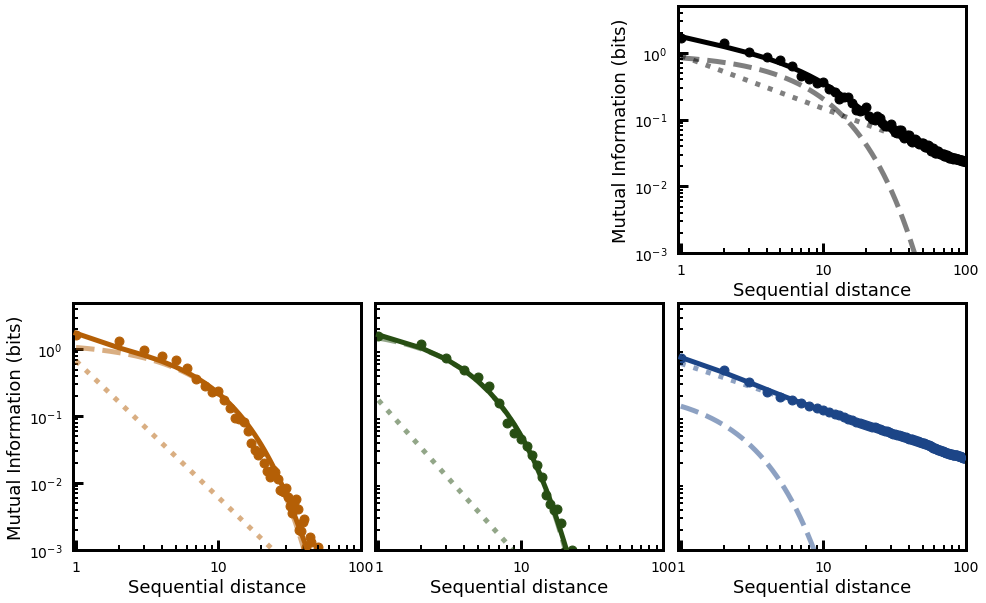

In [123]:
fig, axs = plt.subplots(ncols = 3, nrows=2, figsize=(16,10), gridspec_kw = {'wspace':0.05})


for ax, shuffle, color, color2 in [
    (axs[0,2], 'original', 'k', "#999999"),
    (axs[1,0], 'shuffle_utterance_within_transcript', '#b45f06', "#fce5cdff"),
    (axs[1,1], 'within_transcript_shuffle', '#274e13', "#d9ead3ff"),
    (axs[1,2], 'within_markov_shuffle', "#1c4587", "#cfe2f3ff"),
]:
    row = MI_DF[MI_DF.shuffle==shuffle].iloc[0]
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    nplot=100
    ax.scatter(d[:nplot], MI[:nplot], color=color, s= 80)
    
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances

    dist_mask = distances <= 100
    distances = distances[dist_mask]
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    sig = sig[dist_mask]
    
    if row.bestfitmodel == "pow_exp":
        y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
        y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
        y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
        y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
        y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)

    elif row.bestfitmodel == "pow":
        y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)
        y_pow = None

    elif row.bestfitmodel == "exp":
        y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)
        y_pow = None
    
    if y_pow is not None:
        ax.plot(distances_model, y_pow, ls='dotted', color= color, lw=5, alpha=0.5)
        ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= color, lw=5, alpha=0.5)

    # plot modelled data
    ax.plot(distances, y_model, alpha = 1, lw=5, color=color, zorder=10)
    #ax.set_title("{} {}".format(shuffle, row.bestfitmodel))


for axi, ax in enumerate(axs.flatten()[:2]):
    ax.axis('off')

for axi, ax in enumerate(axs.flatten()[2:]):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Sequential distance', fontsize=18)
    if axi in [0,1]:
        ax.set_ylabel('Mutual Information (bits)', fontsize=18)
    else:
        ax.set_yticks([])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    ax.grid(False)
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)

    ax.set_xticks([1,10,100])
    ax.set_xticklabels(['4','8','50'])
    ax.set_xlim([0.95,100])

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim([1e-3, 5])

save_fig(FIGURE_DIR/'model_shuffle')

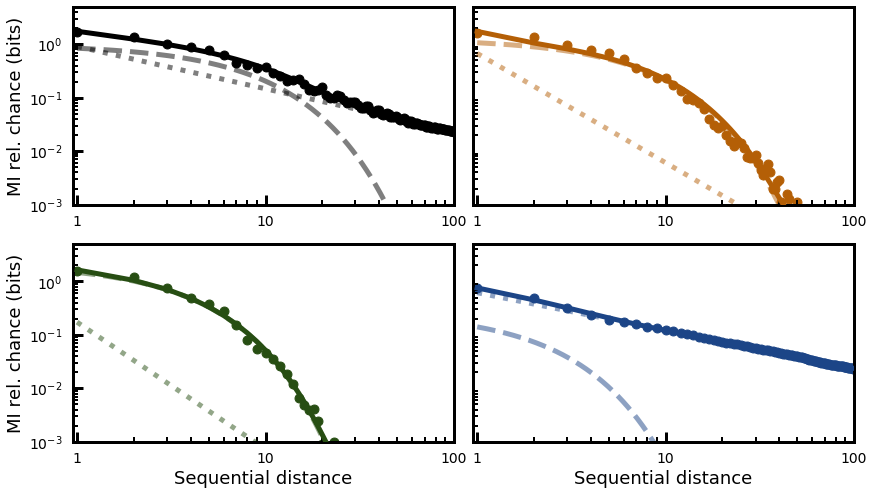

In [132]:
fig, axs = plt.subplots(ncols = 2, nrows=2, figsize=(14,8), gridspec_kw = {'wspace':0.05})


for ax, shuffle, color, color2 in [
    (axs[0,0], 'original', 'k', "#999999"),
    (axs[0,1], 'shuffle_utterance_within_transcript', '#b45f06', "#fce5cdff"),
    (axs[1,0], 'within_transcript_shuffle', '#274e13', "#d9ead3ff"),
    (axs[1,1], 'within_markov_shuffle', "#1c4587", "#cfe2f3ff"),
]:
    row = MI_DF[MI_DF.shuffle==shuffle].iloc[0]
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    nplot=100
    ax.scatter(d[:nplot], MI[:nplot], color=color, s= 80)
    
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances

    dist_mask = distances <= 100
    distances = distances[dist_mask]
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    sig = sig[dist_mask]
    
    if row.bestfitmodel == "pow_exp":
        y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
        y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
        y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
        y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
        y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)

    elif row.bestfitmodel == "pow":
        y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)
        y_pow = None

    elif row.bestfitmodel == "exp":
        y_model = mf.get_y(mf.exp_decay, row.exp_results, distances)
        y_pow = None
    
    if y_pow is not None:
        ax.plot(distances_model, y_pow, ls='dotted', color= color, lw=5, alpha=0.5)
        ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= color, lw=5, alpha=0.5)

    # plot modelled data
    ax.plot(distances, y_model, alpha = 1, lw=5, color=color, zorder=10)
    #ax.set_title("{} {}".format(shuffle, row.bestfitmodel))



for axi, ax in enumerate(axs.flatten()):
    ax.set_yscale('log')
    ax.set_xscale('log')
    if axi in [2,3]:
        ax.set_xlabel('Sequential distance', fontsize=18)
    if axi in [0,2]:
        ax.set_ylabel('MI rel. chance (bits)', fontsize=18)
    else:
        ax.set_yticks([])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')
    ax.grid(False)
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)

    ax.set_xticks([1,10,100])
    ax.set_xticklabels(['4','8','50'])
    ax.set_xlim([0.95,100])

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim([1e-3, 5])

save_fig(FIGURE_DIR/'model_shuffle')